In [1]:
!pip install pylsd
!pip install 'ocrd-fork-pylsd == 0.0.3'

     |████████████████████████████████| 44 kB 519 kB/s eta 0:00:011
  Created wheel for pylsd: filename=pylsd-0.0.2-py3-none-any.whl size=46364 sha256=4ff2fff4abb340b93849fc394cd6026cba0935b860355ec85be6a4ddae8ca318
  Stored in directory: /Users/nakamurasatoru/Library/Caches/pip/wheels/9b/63/9d/790450d057de8c5fc9ed261526ce13048db7e365ef5f53ca0e
Successfully built pylsd
     |████████████████████████████████| 47 kB 514 kB/s eta 0:00:011


In [2]:
import numpy as np
import keras.models
import tensorflow as tf
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch
from urllib import request
import json
import requests
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")
from pylsd.lsd import lsd
import cv2
from scipy.signal import argrelmin, argrelmax
import statistics

%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
!pip install gdown

In [ ]:
!gdown "https://drive.google.com/uc?id=1lu739RJi0wNQ5neWJ71zzaDVZqhvjoE5"

Downloading...
From: https://drive.google.com/uc?id=1lu739RJi0wNQ5neWJ71zzaDVZqhvjoE5
To: /Users/nakamurasatoru/git/d_nijl/ruler/best.pt
 39%|███████████████▍                        | 67.1M/173M [04:04<05:34, 318kB/s]

In [7]:
# 物体検出モデル（best.pt）
# !gdown "https://drive.google.com/uc?id=1lu739RJi0wNQ5neWJ71zzaDVZqhvjoE5"

# ロード
model = torch.hub.load('ultralytics/yolov5', 'custom', path='./best.pt') # .autoshape()  # force_reload = recache latest code

zsh:1: no matches found: https://drive.google.com/uc?id=1lu739RJi0wNQ5neWJ71zzaDVZqhvjoE5


Using cache found in /Users/nakamurasatoru/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-11-17 torch 1.10.0 CPU



Exception: Cache may be out of date, try `force_reload=True`. See https://github.com/ultralytics/yolov5/issues/36 for help.

--2022-01-20 16:32:46--  https://rmda.kulib.kyoto-u.ac.jp/iiif/RB00020027/RB00020027_00001_0.ptif/16512,327,1872,1200/full/0/default.jpg
rmda.kulib.kyoto-u.ac.jp (rmda.kulib.kyoto-u.ac.jp) をDNSに問いあわせています... 64:ff9b::8236:d728, 130.54.215.40
rmda.kulib.kyoto-u.ac.jp (rmda.kulib.kyoto-u.ac.jp)|64:ff9b::8236:d728|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 特定できません [image/jpeg]
`tmp.jpg' に保存中

tmp.jpg                 [   <=>              ] 311.46K   669KB/s 時間 0.5s       

2022-01-20 16:32:48 (669 KB/s) - `tmp.jpg' へ保存終了 [318933]



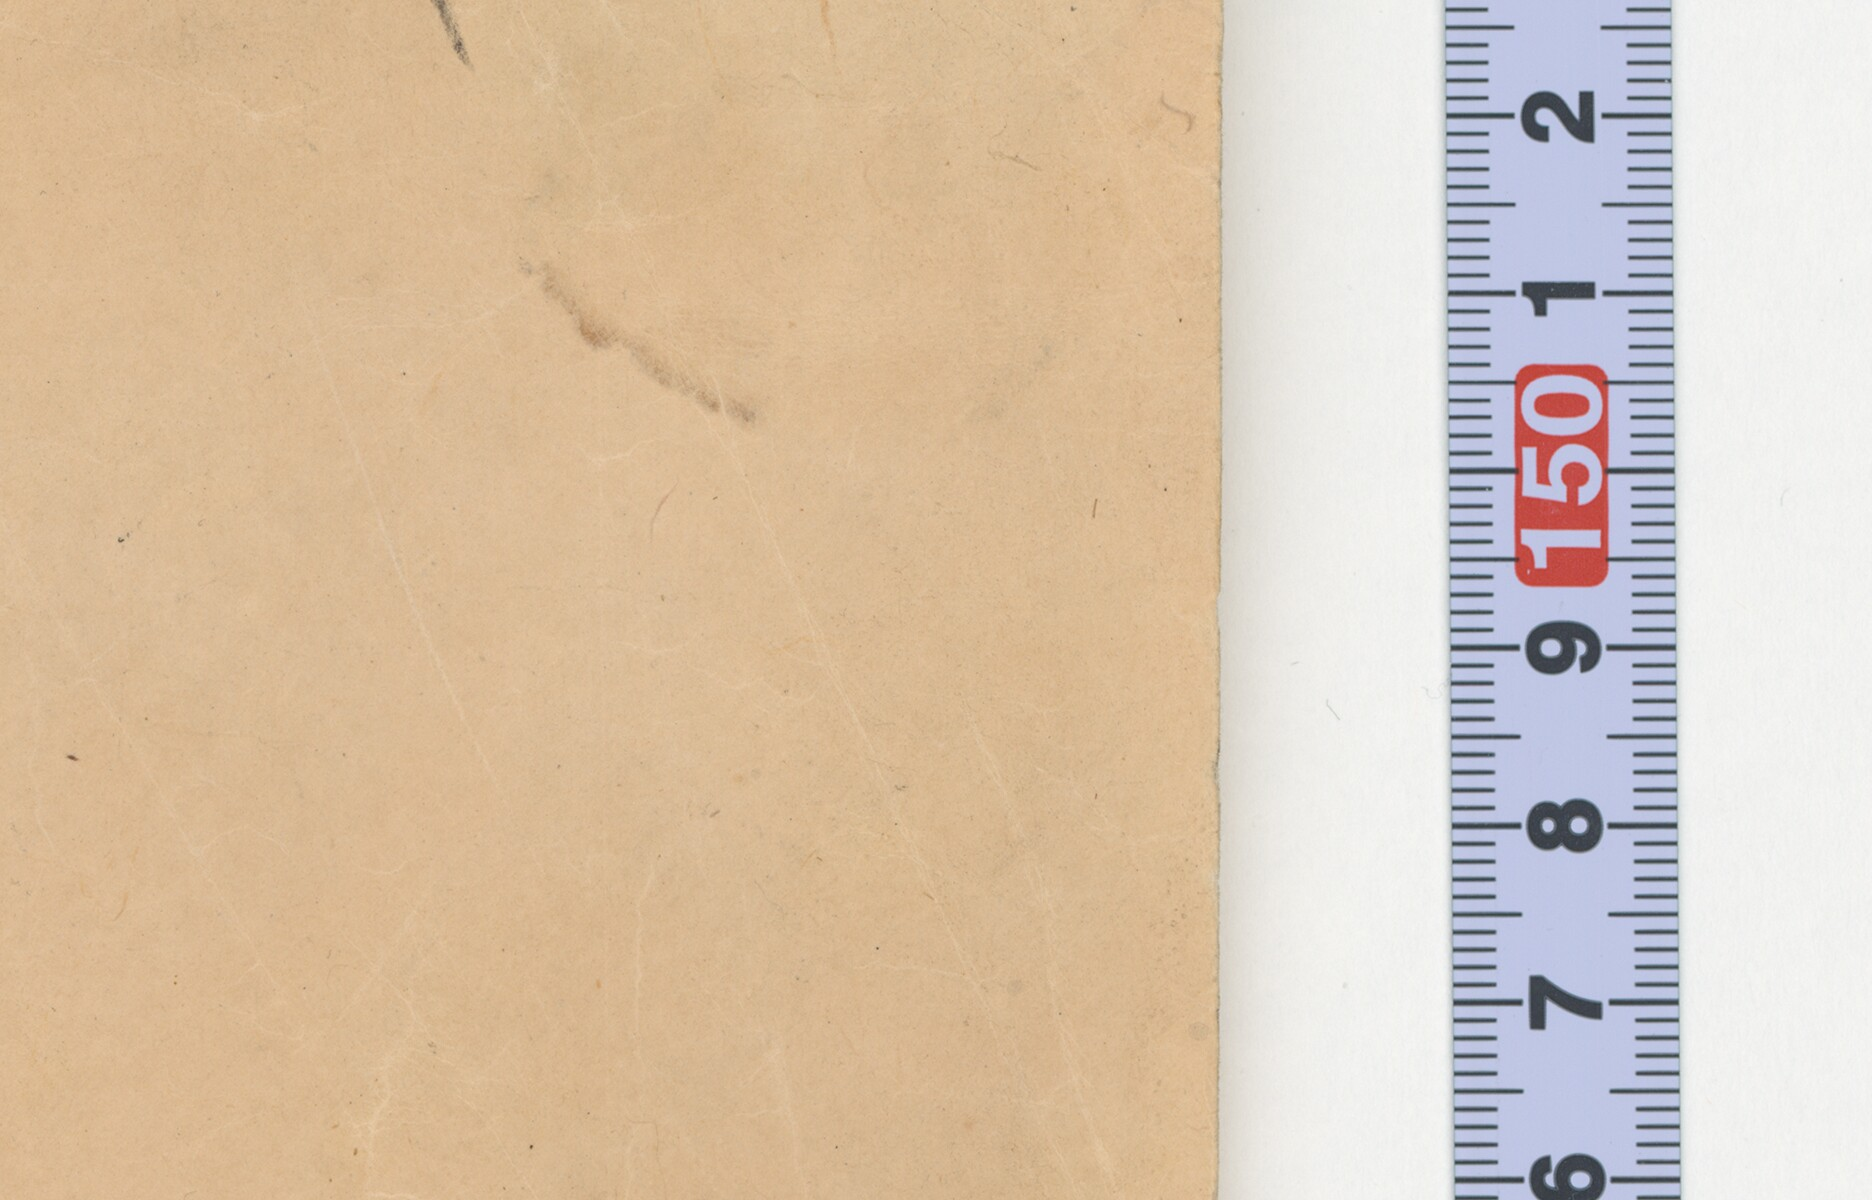

入力画像サイズ: 1872 px x 1200 px


In [4]:
key = "kyoto"

####

collection = {
    "sat": {
        "url" : "https://candra.dhii.jp/iipsrv/iipsrv.fcgi?IIIF=/kakouzou_pub/001_1/0001s.tif/full/full/0/default.jpg"
    },
    "nijl": {
        "url" : "https://kotenseki.nijl.ac.jp/api/iiif/100302677/v4/KANS/KANS-00281/KANS-00281-00002.tif/full/full/0/default.jpg"
    },
    "kyoto": {
        "iiif" : "https://rmda.kulib.kyoto-u.ac.jp/iiif/RB00020027/RB00020027_00001_0.ptif/16512,327,1872,1200/full/0/default.jpg"
    },
    "kyushu": {
        "url" : "https://catalog.lib.kyushu-u.ac.jp/image/iiif/820/1467768/467234.tiff/full/full/0/default.jpg"
    }
}

#####

item = collection[key]

if "iiif" in item:
  url = item["iiif"]
  type = "iiif"
else:
  url = item["url"]
  type = "url"

filename = "tmp.jpg"
!wget -O $filename $url

from IPython.display import Image,display_jpeg
display_jpeg(Image(filename))

img = cv2.imread(filename)
org_w = img.shape[1]
org_h = img.shape[0]
print("入力画像サイズ: {} px x {} px".format(org_w, org_h))